In [ ]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
# Load data
data = pd.read_csv("/content/advertising.csv")


      TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3   12.0
3  151.5   41.3       58.5   16.5
4  180.8   10.8       58.4   17.9


In [ ]:
# Check for null values
print(data.isnull().sum())

# Check for duplicates
print("Duplicates:", data.duplicated().sum())

# Display datatypes
print(data.dtypes)


TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64
Duplicates: 0
TV           float64
Radio        float64
Newspaper    float64
Sales        float64
dtype: object


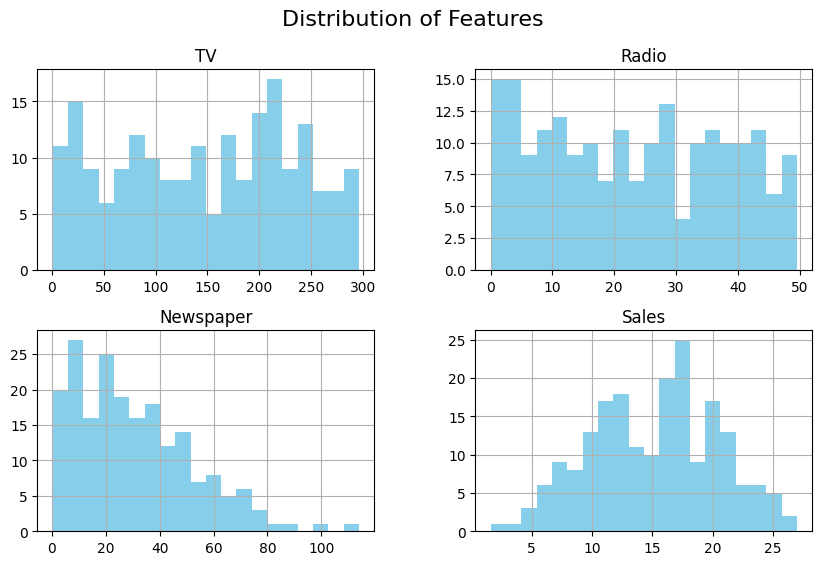

In [ ]:
data.hist(bins=20, figsize=(10, 6), color='skyblue')
plt.suptitle("Distribution of Features", fontsize=16)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


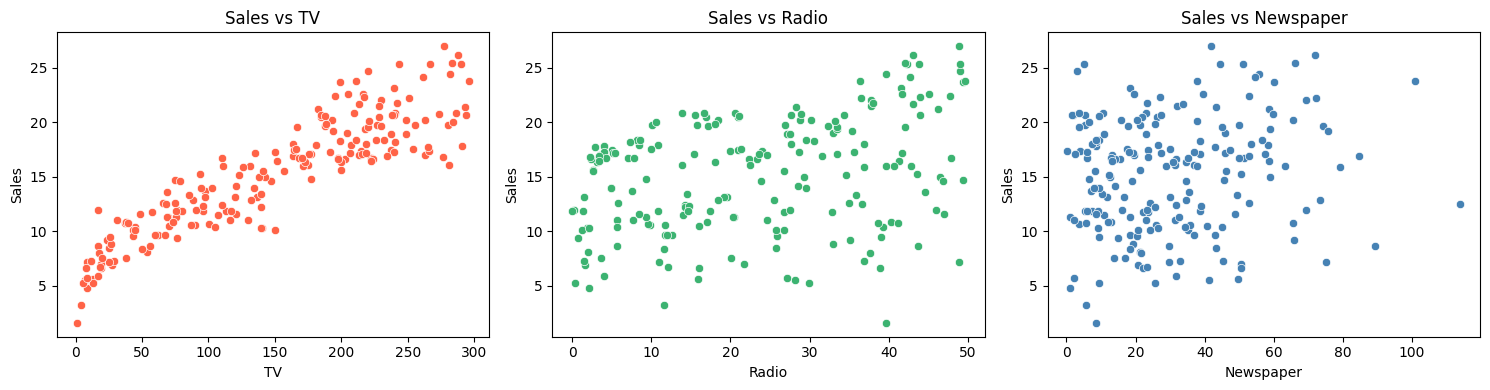

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(x='TV', y='Sales', data=data, color='tomato')
plt.title("Sales vs TV")

plt.subplot(1, 3, 2)
sns.scatterplot(x='Radio', y='Sales', data=data, color='mediumseagreen')
plt.title("Sales vs Radio")

plt.subplot(1, 3, 3)
sns.scatterplot(x='Newspaper', y='Sales', data=data, color='steelblue')
plt.title("Sales vs Newspaper")

plt.tight_layout()
plt.show()


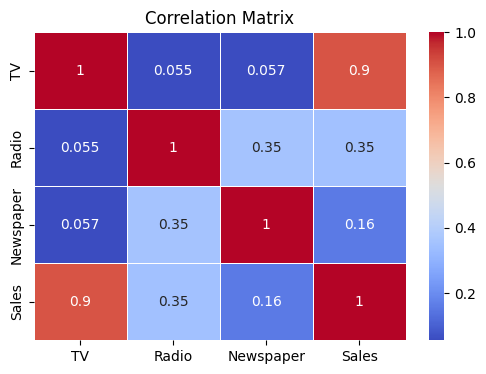

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


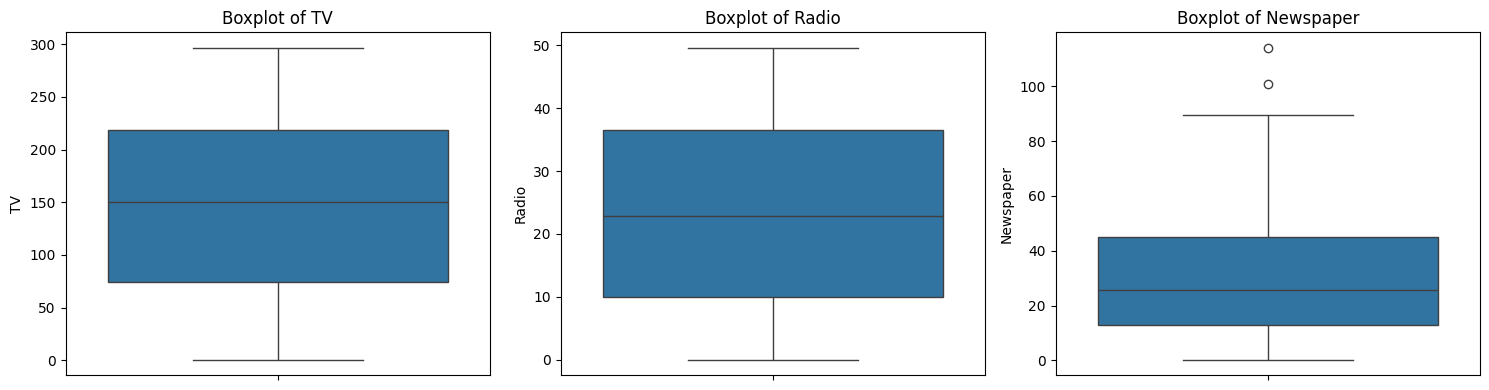

In [ ]:
plt.figure(figsize=(15, 4))

for i, col in enumerate(['TV', 'Radio', 'Newspaper']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


In [ ]:
# Optionally remove extreme Newspaper outliers (threshold can be tuned)
Q1 = data['Newspaper'].quantile(0.25)
Q3 = data['Newspaper'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers only for Newspaper
filtered_data = data[(data['Newspaper'] >= lower_bound) & (data['Newspaper'] <= upper_bound)]
print(f"Data reduced from {len(data)} to {len(filtered_data)} rows after removing outliers.")


Data reduced from 200 to 198 rows after removing outliers.


In [ ]:
# Define features and target
X = filtered_data[['TV', 'Radio', 'Newspaper']]
y = filtered_data['Sales']


In [ ]:
# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [ ]:
# Predictions
y_pred = model.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE:", round(mse, 2))
print("RMSE:", round(rmse, 2))
print("R² Score:", round(r2, 3))


MSE: 2.42
RMSE: 1.55
R² Score: 0.913


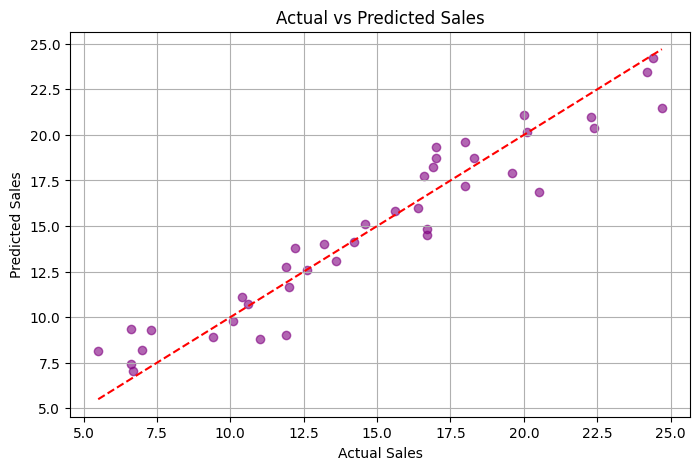

In [ ]:
#Visualize Predictions
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.grid(True)
plt.show()


In [ ]:
# New input (ad budget values) for prediction
new_input = pd.DataFrame({
    'TV': [230.1],
    'Radio': [37.8],
    'Newspaper': [69.2]
})

# Predict sales using the trained model
predicted_sales = model.predict(new_input)

print("Predicted Sales:", round(predicted_sales[0], 2))


Predicted Sales: 21.37


In [ ]:
!pip install streamlit pyngrok


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving advertising.csv to advertising (1).csv


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import joblib

# Load dataset
data = pd.read_csv("advertising.csv")

# Remove outliers (Newspaper)
Q1 = data['Newspaper'].quantile(0.25)
Q3 = data['Newspaper'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['Newspaper'] >= Q1 - 1.5 * IQR) & (data['Newspaper'] <= Q3 + 1.5 * IQR)]

# Train model
X = data[['TV', 'Radio', 'Newspaper']]
y = data['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# Save model
joblib.dump(model, 'sales_model.pkl')

# Start Streamlit App
st.title("Sales Prediction Web App")
st.write("Adjust sliders or upload a CSV to get sales predictions.")

# Sliders for single input
tv = st.slider("TV Budget", 0.0, 300.0, 100.0)
radio = st.slider("Radio Budget", 0.0, 100.0, 25.0)
newspaper = st.slider("Newspaper Budget", 0.0, 120.0, 30.0)

input_df = pd.DataFrame({'TV': [tv], 'Radio': [radio], 'Newspaper': [newspaper]})

if st.button("Predict Sales"):
    model = joblib.load('sales_model.pkl')
    pred = model.predict(input_df)[0]
    st.success(f"Predicted Sales: {round(pred, 2)} units")

# Upload CSV
st.subheader(" Upload CSV for Bulk Prediction")
uploaded_file = st.file_uploader("Choose a CSV file", type=["csv"])

if uploaded_file is not None:
    df_upload = pd.read_csv(uploaded_file)
    model = joblib.load('sales_model.pkl')
    df_upload["Predicted_Sales"] = model.predict(df_upload)
    st.write(df_upload)

    # Save to CSV
    df_upload.to_csv("predictions.csv", index=False)
    st.download_button("Download Predictions", data=df_upload.to_csv(index=False), file_name="predictions.csv")

# Graph - Predicted vs Actual on Test Set
st.subheader(" Predicted vs Actual Sales (Test Data)")
pred_test = model.predict(X_test)
fig, ax = plt.subplots()
ax.plot(y_test.values, label="Actual", marker='o')
ax.plot(pred_test, label="Predicted", marker='x')
plt.xlabel("Sample")
plt.ylabel("Sales")
plt.legend()
st.pyplot(fig)


Overwriting app.py
